In [1]:
import numpy
import scipy
import netCDF4
import matplotlib.pyplot as mp
import matplotlib.ticker
import matplotlib.colors
import scipy.stats
import pandas
import itertools
import mpl_toolkits.axes_grid1

from mpl_toolkits import basemap

mp.rcParams.update({'mathtext.default': 'regular'})
% matplotlib inline

# Alternative test:  instead of using month-specific percentiles, use percentiles over whole season

In [2]:
PRECT_lat = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lat.npy')
PRECT_lon = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/PRECT_lon.npy')

In [3]:
PRECT_nlat = 26
PRECT_nlon = 25

latlon_indices = list(itertools.product(range(PRECT_nlat), range(PRECT_nlon)))
region = 'whole_domain'
window=1

year_start_pic = 402 #time_subsets[chunk,0]
year_end_pic = 2200 #time_subsets[chunk,1]
year_start = 1920
year_end = 2100

In [4]:
year_start_list = numpy.arange(1920,2071)
year_end_list = numpy.arange(1950,2101)

whiplash_ratios_all = numpy.zeros(( year_start_list.size, len(latlon_indices) ))
whiplash_counts_pic_all = numpy.zeros(( year_start_list.size, len(latlon_indices) ))
whiplash_counts_rcp_all = numpy.zeros(( year_start_list.size, len(latlon_indices) ))

# create list of names of members '001','002','003', ...
ensemble_members = numpy.hstack((numpy.arange(1,36), numpy.arange(101,106)))
ensemble_names = ['{:03d}'.format(i) for i in ensemble_members]

working_dir = '/Users/baird/Dropbox/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/whole_domain/'

In [5]:
# create season strings
years_hist_rcp = numpy.arange(1920, 2100+1, 1).astype(numpy.int)

idx_2003 = numpy.where(years_hist_rcp==2003)[0][0]
idx_2033 = numpy.where(years_hist_rcp==2033)[0][0]
idx_2070 = numpy.where(years_hist_rcp==2070)[0][0]
idx_2100 = numpy.where(years_hist_rcp==2100)[0][0]

season_strings_hist_rcp = [str(years_hist_rcp[i])+'-'+str(years_hist_rcp[i+1]) for i in range(years_hist_rcp.size-1)]
#print(season_strings_hist_rcp[idx_2003:idx_2033])

n_seasons_hist_rcp = 2100-1920
#print(len(season_strings_hist_rcp))

In [6]:
# import monthly pic data
working_dir = '/Users/baird/Dropbox/_data_original/NCAR_LENS/daily/PRECT/calculated_npy_files/whole_domain_MONTHLY_TOTALS/'
monthly_data_pic = numpy.load(working_dir+'member_005_years_0402-2200_threshold_0.1mmday_whole_domain.npy')
#print(monthly_data_pic.shape)
# (26, 25, 1799, 12)

monthly_data_pic_NDJFM = numpy.zeros((26,25,1798,5))

monthly_data_pic_NDJFM[:,:,:,0] = monthly_data_pic[:,:,:1798,10]
monthly_data_pic_NDJFM[:,:,:,1] = monthly_data_pic[:,:,:1798,11]
monthly_data_pic_NDJFM[:,:,:,2] = monthly_data_pic[:,:,1:,0]
monthly_data_pic_NDJFM[:,:,:,3] = monthly_data_pic[:,:,1:,1]
monthly_data_pic_NDJFM[:,:,:,4] = monthly_data_pic[:,:,1:,2]

In [7]:
# import monthly RCP data
monthly_data_hist_rcp = []
for ens_name in ensemble_names:
    monthly_data_hist_rcp.append(numpy.load(working_dir+'PRECT_monthly_data_member_' +ens_name+ '_years_1920-2100_threshold_0.1mmday_whole_domain.npy'))
monthly_data_hist_rcp = numpy.array((monthly_data_hist_rcp))
#print(monthly_data_hist_rcp.shape)
# (40, 26, 25, 181, 12)

# store just NDJFM
monthly_data_hist_rcp_NDJFM = numpy.zeros((40,26,25,180,12))
monthly_data_hist_rcp_NDJFM[:,:,:,:,0] = monthly_data_hist_rcp[:,:,:,:180,10]
monthly_data_hist_rcp_NDJFM[:,:,:,:,1] = monthly_data_hist_rcp[:,:,:,:180,11]
monthly_data_hist_rcp_NDJFM[:,:,:,:,2] = monthly_data_hist_rcp[:,:,:,1:,0]
monthly_data_hist_rcp_NDJFM[:,:,:,:,3] = monthly_data_hist_rcp[:,:,:,1:,1]
monthly_data_hist_rcp_NDJFM[:,:,:,:,4] = monthly_data_hist_rcp[:,:,:,1:,2]

In [25]:
# calculate 80th, 20th percentiles for PIC for each month
hi_perc = 95
lo_perc = 5

monthly_data_pic_NDJFM_reshape = monthly_data_pic_NDJFM.reshape((26,25,-1))
print(monthly_data_pic_NDJFM.shape) # 

#pic_hi_perc_NDJFM = numpy.percentile(monthly_data_pic_NDJFM_reshape, hi_perc, axis=2) # 26x25x5
#pic_lo_perc_NDJFM = numpy.percentile(monthly_data_pic_NDJFM_reshape, lo_perc, axis=2) # 26x25x5

pic_hi_perc_NDJFM = numpy.percentile(monthly_data_pic_NDJFM, hi_perc, axis=2) # 26x25x5
pic_lo_perc_NDJFM = numpy.percentile(monthly_data_pic_NDJFM, lo_perc, axis=2) # 26x25x5

(26, 25, 1798, 5)


In [26]:
# whiplash events for pic runs
whiplash_lotohi_count_pic = numpy.zeros((1798,26,25))
whiplash_hitolo_count_pic = numpy.zeros((1798,26,25))
for lat_idx in range(26):
    for lon_idx in range(25):
        for s in range(1798):
            for m in range(5-1):
                # lo to hi
                m_val = monthly_data_pic_NDJFM[lat_idx,lon_idx,s,m]
                m_plus_one_val = monthly_data_pic_NDJFM[lat_idx,lon_idx,s,m+1]
                
                if ( (m_val<pic_lo_perc_NDJFM[lat_idx,lon_idx,m]) and (m_plus_one_val>pic_hi_perc_NDJFM[lat_idx,lon_idx,m+1]) ):
                    whiplash_lotohi_count_pic[s,lat_idx,lon_idx]+=1
                if ( (m_val>pic_hi_perc_NDJFM[lat_idx,lon_idx,m]) and (m_plus_one_val<pic_lo_perc_NDJFM[lat_idx,lon_idx,m+1]) ):
                    whiplash_hitolo_count_pic[s,lat_idx,lon_idx]+=1

In [10]:
#whiplash_pic = whiplash_hitolo_count_pic#+whiplash_lotohi_count_pic
whiplash_pic = whiplash_lotohi_count_pic#+whiplash_hitolo_count_pic
#whiplash_pic = whiplash_hitolo_count_pic+whiplash_lotohi_count_pic

whiplash_pic_alltime = numpy.sum(whiplash_pic, axis=0)

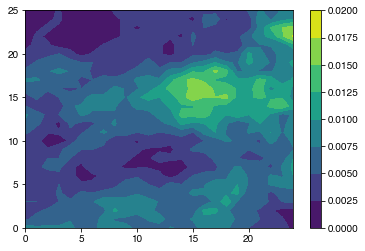

In [11]:
plot_array = whiplash_pic_alltime#+whiplash_hitolo_count_pic
#plot_array = whiplash_hitolo_count_pic
cf=mp.contourf(plot_array/1798)
mp.colorbar(cf)

In [27]:
# whiplash events for RCP runs
whiplash_lotohi_count_hist_rcp = numpy.zeros((180,40,26,25))
whiplash_hitolo_count_hist_rcp = numpy.zeros((180,40,26,25))
for ens_idx in range(40):
    print(ens_idx)
    for lat_idx in range(26):
        for lon_idx in range(25):
            for s in range(180):
                for m in range(5-1):
                    # lo to hi
                    m_val = monthly_data_hist_rcp_NDJFM[ens_idx,lat_idx,lon_idx,s,m]
                    m_plus_one_val = monthly_data_hist_rcp_NDJFM[ens_idx,lat_idx,lon_idx,s,m+1]
                    if ( (m_val<pic_lo_perc_NDJFM[lat_idx,lon_idx,m]) and (m_plus_one_val>pic_hi_perc_NDJFM[lat_idx,lon_idx,m+1]) ):
                        whiplash_lotohi_count_hist_rcp[s,ens_idx,lat_idx,lon_idx]+=1
                    if ( (m_val>pic_hi_perc_NDJFM[lat_idx,lon_idx,m]) and (m_plus_one_val<pic_lo_perc_NDJFM[lat_idx,lon_idx,m+1]) ):
                        whiplash_hitolo_count_hist_rcp[s,ens_idx,lat_idx,lon_idx]+=1


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


# Choose to only account for lo-to-hi, hi-to-lo, or both

In [28]:
#whiplash_hist_rcp = whiplash_hitolo_count_hist_rcp# + whiplash_lotohi_count_hist_rcp
whiplash_hist_rcp = whiplash_lotohi_count_hist_rcp# + whiplash_hitolo_count_hist_rcp
#whiplash_hist_rcp = whiplash_lotohi_count_hist_rcp + whiplash_hitolo_count_hist_rcp

print(whiplash_hist_rcp.shape)

whiplash_all_ens_alltime_hist_rcp = numpy.mean(whiplash_hist_rcp, axis=0)
print(whiplash_all_ens_alltime_hist_rcp.shape)
whiplash_all_ens_alltime_hist_rcp = numpy.mean(whiplash_all_ens_alltime_hist_rcp, axis=0)
print(whiplash_all_ens_alltime_hist_rcp.shape)

(180, 40, 26, 25)
(40, 26, 25)
(26, 25)


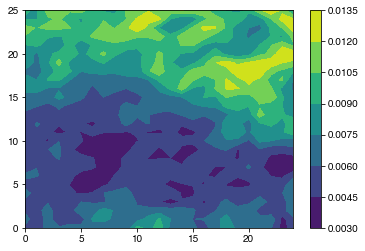

In [29]:
cf=mp.contourf(whiplash_all_ens_alltime_hist_rcp)
mp.colorbar(cf)

# Whiplash for 2003-2033 and 2070-2100

# Calculate whiplash ratios relative to PIC

In [30]:
print(whiplash_hist_rcp.shape)

(180, 40, 26, 25)


In [31]:
whiplash_hist_rcp_alltime = numpy.sum(whiplash_hist_rcp, axis=1)
#print(whiplash_hist_rcp_alltime.shape) # 180x26x25

whiplash_hist_rcp_2003_2033 = numpy.sum(whiplash_hist_rcp_alltime[idx_2003:idx_2033,:,:], axis=0)
whiplash_hist_rcp_2070_2100 = numpy.sum(whiplash_hist_rcp_alltime[idx_2070:idx_2100,:,:], axis=0)

# whiplash events for pic runs
pic_freq = (whiplash_pic_alltime/1798)
# times per century for RCP8.5-like warming
rcp_freq_2003_2033 = (whiplash_hist_rcp_2003_2033/(40*30))
rcp_freq_2070_2100 = (whiplash_hist_rcp_2070_2100/(40*30))

wr_2003_2033 = rcp_freq_2003_2033/pic_freq
wr_2070_2100 = rcp_freq_2070_2100/pic_freq

# Calculate time-latitude array

In [32]:
cali_coast_latlon_indices = numpy.load('/Users/baird/Dropbox/_analysis/attribution_2017/NEW_CALCULATIONS/npy_files/coastal_latlon_array_indices_3x.npy')
cali_coast_latlon_indices_zip = [i for i in zip(cali_coast_latlon_indices[:,0], cali_coast_latlon_indices[:,1])]

cali_coast_latlon_indices_3d = cali_coast_latlon_indices.reshape((11,3,2))
#print(cali_coast_latlon_indices_3d[0,:,:])

# Pull out LA specific lat/lon

In [33]:
print(whiplash_hist_rcp.shape)
print(whiplash_pic.shape)

whiplash_hist_rcp_LA = whiplash_hist_rcp[:,:,9,17].sum(axis=1) # sum across ensemble members
whiplash_pic_LA = whiplash_pic[:,9,17]

#pic_counts_LA = pic_counts_reshape[9,17]
#hist_rcp_counts_LA = hist_rcp_counts_reshape[9,17,:]

(180, 40, 26, 25)
(1798, 26, 25)


10


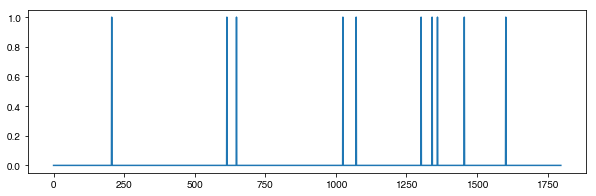

In [34]:
fig = mp.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.plot(whiplash_pic_LA)
print(numpy.sum(whiplash_pic_LA>0))

0.00583333333333


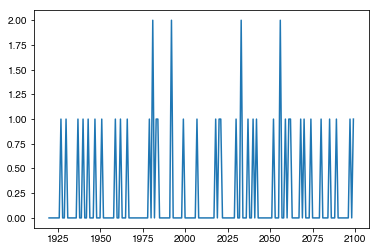

In [35]:
mp.plot(numpy.arange(1920,2100), whiplash_hist_rcp_LA)
print(numpy.sum(whiplash_hist_rcp_LA[whiplash_hist_rcp_LA>0])/(40*180))

In [36]:
window=1
whiplash_pic_LA_rolling = pandas.Series(whiplash_pic_LA).rolling(window=window).mean()
whiplash_hist_rcp_LA_rolling = pandas.Series(whiplash_hist_rcp_LA).rolling(window=window).mean()

0.005833333333333334


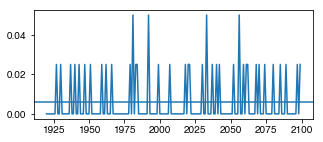

In [37]:
fig = mp.figure(figsize=(5,2))

ax = fig.add_subplot(111)

ax.plot(numpy.arange(1920,2100), whiplash_hist_rcp_LA_rolling/40)
ax.axhline(whiplash_hist_rcp_LA_rolling.mean()/40)

print(whiplash_hist_rcp_LA_rolling.mean()/40)

0.0055617352614015575


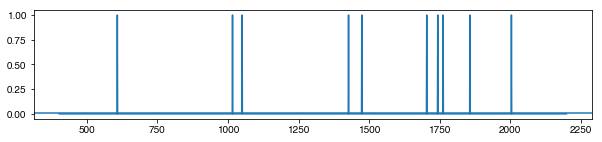

In [38]:
fig = mp.figure(figsize=(10,2))

ax = fig.add_subplot(111)

ax.plot(numpy.arange(402,2200), whiplash_pic_LA_rolling)
ax.axhline(whiplash_pic_LA_rolling.mean())
print(whiplash_pic_LA_rolling.mean())
